In [ ]:
# moderate+severe => 1 class

In [1]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, accuracy_score
from nca import *
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier as kNN
import matplotlib
%matplotlib inline
import seaborn as sns; sns.set()
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from IPython.display import HTML
from tqdm import tqdm
import pdb
import pickle

In [2]:
def compute_pij_matrix(A, inp):
#     pdb.set_trace()
    trans_inp = transform(A, inp)
    sample_num = inp.shape[0]
    v_mat = np.tile(np.expand_dims(trans_inp, axis=0), (sample_num,1,1))
    h_mat = np.tile(np.expand_dims(trans_inp, axis=1), (1,sample_num,1))
    pij_mat = np.sum((h_mat[:,:,:2]-v_mat[:,:,:2])**2, axis=-1)
    pij_mat = np.exp(-pij_mat)-np.eye(sample_num)
    sum = np.sum(pij_mat, axis = -1)
    sum_mat = np.tile(np.expand_dims(sum, axis=1), (1, sample_num))
    pij_mat = np.divide(pij_mat, sum_mat)
    return pij_mat

def nca_fast(A, inp, label, lr=0.5):
    pij_mat = compute_pij_matrix(A, inp)
    diff = 0
    for i in range(inp.shape[0]):
        p = 0.
        for j in range(inp.shape[0]):
            if label[i] == label[j]:
                p += pij_mat[i,j]
        first_term = np.zeros( (inp.shape[1], inp.shape[1]) )
        second_term = np.zeros( (inp.shape[1], inp.shape[1]) )
        for k in range(inp.shape[0]):
            xik = inp[i] - inp[k]
            pik = pij_mat[i, k]
            term = pik * np.outer(xik, xik)
            first_term += term
            if label[k] == label[i]:
                second_term += term
        first_term *= p
        diff += first_term-second_term
    A += lr*2*np.matmul(A, diff)
    return A

def transform(A, inp):
    # out = np.zeros(inp.shape)
    # for i in range(len(out)):
    #     out[i] = applyA(A, inp[i])
    # return out 
    A_T = np.transpose(A)
    return np.matmul(inp, A_T)

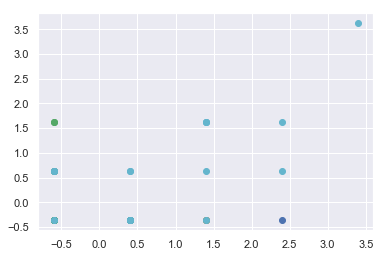

In [3]:
data_frame = pd.read_excel('../NEW_AVON_newdata_comparative_CombineProspective_GetNoneLE_AllWithSym_ProcessedData.xlsx', sheetname='Sheet1')

labels = data_frame['LEStage']

df = pd.DataFrame(data_frame)

data = df.drop(['LEStage', 'AffectedLV', 'Non-AffectLV', 'LESYM17_Blister'], axis=1)

X = np.matrix(data)
std = np.std(X, axis=0)
mean = np.mean(X, axis=0)
X = X-mean
# X = X/std
y = labels

# # Merge severe into moderate
# for idx in range(len(y)):
#     if y[idx] == 3:
#         y[idx] = 2
        

Xcl1 = np.matrix(X[y == 0])
Xcl2 = np.matrix(X[y == 1])
Xcl3 = np.matrix(X[y == 2])
Xcl4 = np.matrix(X[y == 3])

cl1, = plt.plot(Xcl1[:,0], Xcl1[:,1], linestyle='', marker='o', color='b')
cl2, = plt.plot(Xcl2[:,0], Xcl2[:,1], linestyle='', marker='o', color='r')
cl3, = plt.plot(Xcl3[:,0], Xcl3[:,1], linestyle='', marker='o', color='g')
cl4, = plt.plot(Xcl4[:,0], Xcl4[:,1], linestyle='', marker='o', color='c')
# plt.xlim((-0.5, 0.5))
# plt.ylim((-0.5, 0.5))

In [8]:
pca = PCA(n_components=23)
pca.fit(X)
A = pca.components_[-2:]
Xtrfmed = []
accs = []
diffs = []
A_list = []
n_elements_in_A = A.shape[0]*A.shape[1]

A += np.random.rand(2, X.shape[1])/50

In [6]:
# 0.86764
np.random.seed(128)
# We can initialise the transformation matrix to # We ca 
# anything we like, here we choose a diagonal matrix.
# A = np.random.rand(X.shape[1],X.shape[1])
A = np.random.rand(2, X.shape[1])
A = np.divide(A.T, np.sum(A, axis=1))
A = A.T
# A[1,1] = 1
# A[1,0] = 1
# Store the transformed data, accuracies and the delta_A at each iteration
Xtrfmed = []
accs = []
diffs = []
n_elements_in_A = A.shape[0]*A.shape[1]

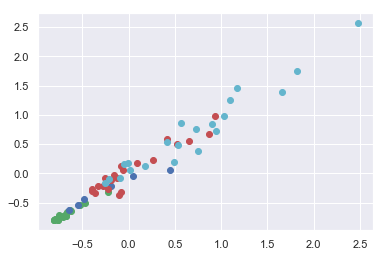

In [7]:
Xtransformed = transform(A, X)
Xcl1 = np.matrix(Xtransformed[y == 0])
Xcl2 = np.matrix(Xtransformed[y == 1])
Xcl3 = np.matrix(Xtransformed[y == 2])
Xcl4 = np.matrix(Xtransformed[y == 3])

cl1, = plt.plot(Xcl1[:,0], Xcl1[:,1], linestyle='', marker='o', color='g')
cl2, = plt.plot(Xcl2[:,0], Xcl2[:,1], linestyle='', marker='o', color='b')
cl3, = plt.plot(Xcl3[:,0], Xcl3[:,1], linestyle='', marker='o', color='r')
cl4, = plt.plot(Xcl4[:,0], Xcl4[:,1], linestyle='', marker='o', color='c')

In [9]:
Xcl1 = np.matrix(X[y == 0])
Xcl2 = np.matrix(X[y == 1])
Xcl3 = np.matrix(X[y == 2])
Xcl4 = np.matrix(X[y == 3])

np.random.shuffle(Xcl1)
np.random.shuffle(Xcl2)
np.random.shuffle(Xcl3)
np.random.shuffle(Xcl4)

ycl1 = np.array(y[y == 0])
ycl2 = np.array(y[y == 1])
ycl3 = np.array(y[y == 2])
ycl4 = np.array(y[y == 3])

len_cl1 = Xcl1.shape[0]
len_cl2 = Xcl2.shape[0]
len_cl3 = Xcl3.shape[0]
len_cl4 = Xcl4.shape[0]

def k_fold_test(k=3):
    size_cl1 = int(len_cl1/k)
    size_cl2 = int(len_cl2/k)
    size_cl3 = int(len_cl3/k)
    size_cl4 = int(len_cl4/k)
    
    dataset = []
    labelset = []
    start_cl1, start_cl2, start_cl3, start_cl4 = 0, 0, 0, 0
    for i in range(k-1):
        dataset.append(np.vstack((Xcl1[start_cl1: start_cl1+size_cl1], 
                                 Xcl2[start_cl2: start_cl2+size_cl2],
                                 Xcl3[start_cl3: start_cl3+size_cl3],
                                 Xcl4[start_cl4: start_cl4+size_cl4])))
#         pdb.set_trace()
        labelset.append(np.concatenate((ycl1[start_cl1: start_cl1+size_cl1], 
                                         ycl2[start_cl2: start_cl2+size_cl2],
                                         ycl3[start_cl3: start_cl3+size_cl3],
                                         ycl4[start_cl4: start_cl4+size_cl4])))
        start_cl1 += size_cl1
        start_cl2 += size_cl2
        start_cl3 += size_cl3
        start_cl4 += size_cl4
        
    dataset.append(np.vstack((Xcl1[start_cl1:], 
                                 Xcl2[start_cl2:],
                                 Xcl3[start_cl3:],
                                 Xcl4[start_cl4:])))
    
    labelset.append(np.concatenate((ycl1[start_cl1:], 
                                 ycl2[start_cl2:],
                                 ycl3[start_cl3:],
                                 ycl4[start_cl4:])))
    
    return dataset, labelset

In [10]:
dataset, labelset  = k_fold_test()
# pickle.dump(dataset, open('dataset2.p', 'wb'))
# pickle.dump(labelset, open('labelset2.p', 'wb'))

In [11]:
# This is a method to get the accuracy (using leave-one-out validation) of the data# This  
def assess_perf(clf, X, y, scoring='accuracy', cv=None):
    if cv is None: cv = LeaveOneOut()
    scores = cross_val_score(clf, X, y, scoring=scoring, cv=cv)
    return np.mean(scores), np.std(scores)

def check_knn_score(neighbors_num):
    knn = kNN(n_neighbors=neighbors_num, weights='distance', algorithm='brute', n_jobs=-1)
    print (assess_perf(knn, X, y, scoring='accuracy'))
    
# check_knn_score(1)
# check_knn_score(3)
# check_knn_score(5)
# check_knn_score(7)

In [12]:
knn = kNN(n_neighbors=3 , weights='distance', algorithm='brute', n_jobs=4)


def training(X, y, A_trans, epochs = 150):
    print ('NCA progress:')
    lr = 5e-3
    count = 0
    A_list = []
    accs = []
    diffs = []
    Xtrfmed = []
    for i in range(epochs): # 200 iterations
        try:
            A_prev = np.copy(A_trans)
            # do  a simple step of the NCA method, matrix A will be updated
            A_trans = nca_fast(A_trans, X, y, lr=lr)
            Adiff = np.sum(np.abs(A_prev - A_trans))/n_elements_in_A  
            Xtransformed = transform(A_trans, X)
            Xtrfmed.append(Xtransformed)
            A_list.append(A_trans)
            acc, _ = assess_perf(knn, Xtransformed, y, scoring='accuracy')
            print ("Epoch: {}, Acc:{}, Per_element_change: {}".format(i, acc, Adiff))
            accs.append(acc)
            diffs.append(Adiff)
            if acc >= 0.95:
                count +=1
                if count > 5:
                    break
        except ValueError:
            break
    print ('Done!')
    return A_trans, A_list, accs, diffs, Xtrfmed

def test(X, y, A):
    Xtransformed = transform(A, X)
    acc, _ = assess_perf(knn, Xtransformed, y, scoring='accuracy')
    print ("Testing accuracy: ", acc)

k = 3

A_fold_list = []
accs_fold_list = []
diffs_fold_list = []
Xtrfmed_list = []

# start_A = np.copy(A)
# print(A)

# First fold:
print ('-'*60)
print ('Fold 1:')
X = np.vstack((dataset[1], dataset[2]))
y = np.concatenate((labelset[1], labelset[2]))
test_X = dataset[0]
test_y = labelset[0]

A_fold, temp_A_list, temp_accs, temp_diffs, temp_xtr = training(X, y, np.copy(A))
A_fold_list.append(temp_A_list)
accs_fold_list.append(temp_accs)
diffs_fold_list.append(temp_diffs)
Xtrfmed_list.append(temp_xtr)
test(test_X, test_y, A_fold)

# pdb.set_trace()
# print(A)

# Second fold:
print ('-'*60)
print ('Fold 2:')
X = np.vstack((dataset[0], dataset[2]))
y = np.concatenate((labelset[0], labelset[2]))
test_X = dataset[1]
test_y = labelset[1]

A_fold, temp_A_list, temp_accs, temp_diffs, temp_xtr = training(X, y, np.copy(A))
A_fold_list.append(temp_A_list)
accs_fold_list.append(temp_accs)
diffs_fold_list.append(temp_diffs)
Xtrfmed_list.append(temp_xtr)
test(test_X, test_y, A_fold)

# print(A)

# Third fold:
print ('-'*60)
print ('Fold 3:')
X = np.vstack((dataset[1], dataset[0]))
y = np.concatenate((labelset[1], labelset[0]))
test_X = dataset[2]
test_y = labelset[2]

A_fold, temp_A_list, temp_accs, temp_diffs, temp_xtr = training(X, y, np.copy(A))
A_fold_list.append(temp_A_list)
accs_fold_list.append(temp_accs)
diffs_fold_list.append(temp_diffs)
Xtrfmed_list.append(temp_xtr)
test(test_X, test_y, A_fold)



------------------------------------------------------------
Fold 1:
NCA progress:
Epoch: 0, Acc:0.3695652173913043, Per_element_change: 0.0026607944347078237
Epoch: 1, Acc:0.5869565217391305, Per_element_change: 0.008028189306025283
Epoch: 2, Acc:0.782608695652174, Per_element_change: 0.02083581495322465
Epoch: 3, Acc:0.8260869565217391, Per_element_change: 0.015739749087276034
Epoch: 4, Acc:0.8260869565217391, Per_element_change: 0.009679350100504172
Epoch: 5, Acc:0.8478260869565217, Per_element_change: 0.007459435154489147
Epoch: 6, Acc:0.8695652173913043, Per_element_change: 0.006243648193005608
Epoch: 7, Acc:0.8695652173913043, Per_element_change: 0.005577943675645858
Epoch: 8, Acc:0.8695652173913043, Per_element_change: 0.005261960021244417
Epoch: 9, Acc:0.8913043478260869, Per_element_change: 0.005143461423184765
Epoch: 10, Acc:0.8913043478260869, Per_element_change: 0.005048317333946863
Epoch: 11, Acc:0.9130434782608695, Per_element_change: 0.004955570241291255
Epoch: 12, Acc:0

In [ ]:
def plot_curve(accs, diffs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    ax1.plot(accs)
    ax2.plot(diffs)
    ax1.set_xlabel('Epochs (iterations)')
    ax2.set_xlabel('Epochs (iterations)')
    ax1.set_ylabel('Accuracy (on tranformed data)')
    ax2.set_ylabel('Per-element change in A')

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate

def anime_plot(Xtrfmed):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10, 20), ylim=(-10, 20))

    #line, = ax.plot([], [], lw=2, color='b')
    cl1, = ax.plot([],[], linestyle='', marker='o', color='b')
    cl2, = ax.plot([],[], linestyle='', marker='o', color='r')
    cl3, = ax.plot([],[], linestyle='', marker='o', color='g')
    cl4, = ax.plot([],[], linestyle='', marker='o', color='c')
    # initialization function: plot the background of each frame
    def init():
        cl1.set_data([], [])
        cl2.set_data([], [])
        cl3.set_data([], [])
        cl4.set_data([], [])
        return [cl1, cl2, cl3, cl4]

    # animation function.  This is called sequentially
    def animate(t):
        X_transformed_at_t = Xtrfmed[t]
        Xtcl1 = X_transformed_at_t[y == 0]
        Xtcl2 = X_transformed_at_t[y == 1]
        Xtcl3 = X_transformed_at_t[y == 2]
        Xtcl4 = X_transformed_at_t[y == 3]
        cl1.set_data(Xtcl1[:,0], Xtcl1[:,1])
        cl2.set_data(Xtcl2[:,0], Xtcl2[:,1])
        cl3.set_data(Xtcl3[:,0], Xtcl3[:,1])
        cl4.set_data(Xtcl4[:,0], Xtcl4[:,1])
        return [cl1, cl2, ]

    # call the animator. 
    anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                   frames=range(len(Xtrfmed)), 
                                   interval=50, blit=True)
    plt.grid(True)
    HTML(anim.to_html5_video())

def result_plot(A, x):
    Xtransformed = transform(A, X)
    plt.figure()
    Xcl1 = np.matrix(Xtransformed[y == 0])
    Xcl2 = np.matrix(Xtransformed[y == 1])
    Xcl3 = np.matrix(Xtransformed[y == 2])
    Xcl4 = np.matrix(Xtransformed[y == 3])

    cl1, = plt.plot(Xcl1[:,0], Xcl1[:,1], linestyle='', marker='o', color='b')
    cl2, = plt.plot(Xcl2[:,0], Xcl2[:,1], linestyle='', marker='o', color='r')
    cl3, = plt.plot(Xcl3[:,0], Xcl3[:,1], linestyle='', marker='o', color='g')
    cl4, = plt.plot(Xcl4[:,0], Xcl4[:,1], linestyle='', marker='o', color='c')

In [ ]:
plot_curve(accs_fold_list[0], diffs_fold_list[0])

In [ ]:
plot_curve(accs_fold_list[1], diffs_fold_list[1])

In [ ]:
plot_curve(accs_fold_list[2], diffs_fold_list[2])

In [ ]:
anime_plot(temp_xtr)

In [ ]:
Xtrfmed = Xtrfmed_list[2]
fig = plt.figure()
ax = plt.axes(xlim=(-10, 20), ylim=(-10, 20))

#line, = ax.plot([], [], lw=2, color='b')
cl1, = ax.plot([],[], linestyle='', marker='o', color='b')
cl2, = ax.plot([],[], linestyle='', marker='o', color='r')
cl3, = ax.plot([],[], linestyle='', marker='o', color='g')
cl4, = ax.plot([],[], linestyle='', marker='o', color='c')
# initialization function: plot the background of each frame
def init():
    cl1.set_data([], [])
    cl2.set_data([], [])
    cl3.set_data([], [])
    cl4.set_data([], [])
    return [cl1, cl2, cl3, cl4]

# animation function.  This is called sequentially
def animate(t):
    X_transformed_at_t = Xtrfmed[t]
    Xtcl1 = X_transformed_at_t[y == 0]
    Xtcl2 = X_transformed_at_t[y == 1]
    Xtcl3 = X_transformed_at_t[y == 2]
    Xtcl4 = X_transformed_at_t[y == 3]
    cl1.set_data(Xtcl1[:,0], Xtcl1[:,1])
    cl2.set_data(Xtcl2[:,0], Xtcl2[:,1])
    cl3.set_data(Xtcl3[:,0], Xtcl3[:,1])
    cl4.set_data(Xtcl4[:,0], Xtcl4[:,1])
    return [cl1, cl2, ]

# call the animator. 
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=range(len(Xtrfmed)), 
                               interval=50, blit=True)
plt.grid(True)
HTML(anim.to_html5_video())

In [ ]:
temp = A_fold_list[-1][-1]
plt.figure()
plt.plot(temp[0])
plt.plot(temp[1])

In [ ]:
data